正在尝试读取文件...
图像形状: (240, 240, 155)


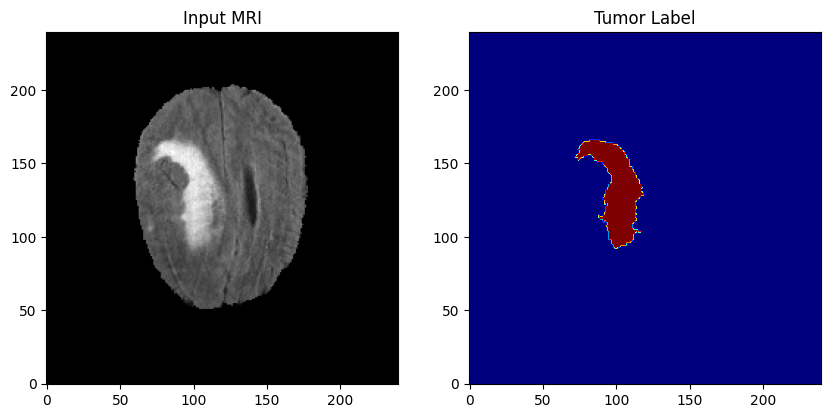

In [1]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import torch

img_path = "dataset/image.nii" 
lbl_path = "dataset/label.nii"

print("正在尝试读取文件...")

# 1. 读取数据

img_data = nib.load(img_path).get_fdata()
lbl_data = nib.load(lbl_path).get_fdata()

print(f"图像形状: {img_data.shape}") 
    
# 2. 可视化
slice_idx = 100
plt.figure(figsize=(10, 5))
    
plt.subplot(1, 2, 1)
plt.imshow(img_data[:, :, slice_idx].T, cmap='gray', origin='lower')
plt.title("Input MRI")
    
plt.subplot(1, 2, 2)
plt.imshow(lbl_data[:, :, slice_idx].T, cmap='jet', origin='lower')
plt.title("Tumor Label")
    
plt.show()


In [2]:
# Numpy--->Tensor
img_2d = img_data[:, :, slice_idx]
lbl_2d = lbl_data[:, :, slice_idx]
img_tensor = torch.from_numpy(img_2d).float().unsqueeze(0).unsqueeze(0)
lbl_tensor = torch.from_numpy(lbl_2d).float().unsqueeze(0).unsqueeze(0)

# Normalization归一化
img_tensor = img_tensor/img_tensor.max()

# Binarization标签二值化
lbl_tensor[lbl_tensor>0] = 1

print(f"✅数据准备完成")
print(f"输出张量形状：{img_tensor.shape}")
print(f"最大像素值:{img_tensor.max().item()}")


✅数据准备完成
输出张量形状：torch.Size([1, 1, 240, 240])
最大像素值:1.0


In [3]:
import monai
from monai.networks.nets import BasicUNet
# --- 1. 激活 Mac 的显卡加速 ---
# 如果有 MPS 就用 MPS，没有就用 CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"🚀 AI 将在设备上运行: {device}")

# --- 2. 定义 U-Net 模型 ---
# 这就是我们要训练的那个“脑子”
model = BasicUNet(
    spatial_dims=2,   # 我们做 2D 处理
    in_channels=1,    # 输入：只有 1 张灰度图 (MRI)
    out_channels=1    # 输出：只有 1 张掩码图 (肿瘤位置)
).to(device)          # .to(device) 把模型搬到显卡上

# --- 3. 把数据也搬到显卡上 ---
img_tensor = img_tensor.to(device)
lbl_tensor = lbl_tensor.to(device)

print("✅ 步骤2完成！U-Net 模型已加载到显卡。")


# --- 1. 定义评分标准 (Loss Function) ---
# 使用 Dice Loss (医学分割专用)
loss_function = monai.losses.DiceLoss(sigmoid=True)

# --- 2. 定义优化器 (Optimizer) ---
# Adam 是最常用的优化算法，lr=1e-3 是学习率
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("✅ 步骤3完成！准备开始训练。")

🚀 AI 将在设备上运行: mps
BasicUNet features: (32, 32, 64, 128, 256, 32).
✅ 步骤2完成！U-Net 模型已加载到显卡。
✅ 步骤3完成！准备开始训练。


In [4]:
print("🚀 开始训练 (Training Start)...")
losses = [] # 用来记录每次考试的分数

# 训练 100 轮
for i in range(100):
    
    # [核心 5 步曲] —— 背下来！
    
    # 1. 梯度清零 (Clean up)
    # 把上一次算的账清空，准备重新算
    optimizer.zero_grad()
    
    # 2. 前向传播 (Forward)
    # AI 看图，给出一个预测结果
    output = model(img_tensor)
    
    # 3. 计算误差 (Compute Loss)
    # 拿 AI 的结果和标准答案对比，算出一个分数
    loss = loss_function(output, lbl_tensor)
    
    # 4. 反向传播 (Backward)
    # 寻找错误的原因（计算梯度）
    loss.backward()
    
    # 5. 更新参数 (Update)
    # 根据原因修改 AI 脑子里的参数
    optimizer.step()
    
    # --- 记录与打印 ---
    losses.append(loss.item())
    if (i + 1) % 10 == 0:
        print(f"Epoch {i+1}/100 - Loss: {loss.item():.4f}")

print("✅ 步骤4完成！模型训练完毕！")

🚀 开始训练 (Training Start)...
Epoch 10/100 - Loss: 0.8831
Epoch 20/100 - Loss: 0.8733
Epoch 30/100 - Loss: 0.8660
Epoch 40/100 - Loss: 0.8576
Epoch 50/100 - Loss: 0.8475
Epoch 60/100 - Loss: 0.8348
Epoch 70/100 - Loss: 0.8196
Epoch 80/100 - Loss: 0.8005
Epoch 90/100 - Loss: 0.7783
Epoch 100/100 - Loss: 0.7515
✅ 步骤4完成！模型训练完毕！


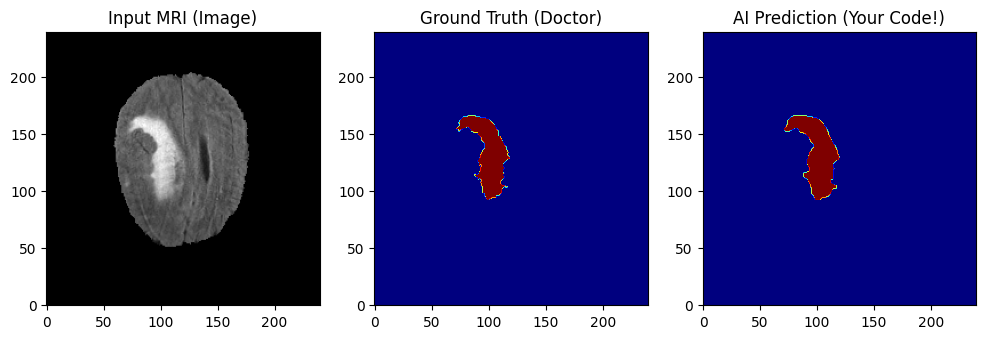

In [5]:
# --- 1. 让训练好的模型再预测一次 ---
with torch.no_grad():
    # 预测
    pred = model(img_tensor)
    # 处理结果：大于 0.5 的算肿瘤，变成 0/1 二值图
    pred_binary = (torch.sigmoid(pred) > 0.5).float()

# --- 2. 画图对比 ---
plt.figure(figsize=(12, 4))

# 原图
plt.subplot(1, 3, 1)
plt.imshow(img_tensor.cpu().numpy()[0, 0].T, cmap='gray', origin='lower')
plt.title("Input MRI (Image)")

# 医生画的
plt.subplot(1, 3, 2)
plt.imshow(lbl_tensor.cpu().numpy()[0, 0].T, cmap='jet', origin='lower')
plt.title("Ground Truth (Doctor)")

# AI 画的
plt.subplot(1, 3, 3)
plt.imshow(pred_binary.cpu().numpy()[0, 0].T, cmap='jet', origin='lower')
plt.title("AI Prediction (Your Code!)")

plt.show()

✅ 高清结果图已保存为 'project.png'！快去文件夹里看看！


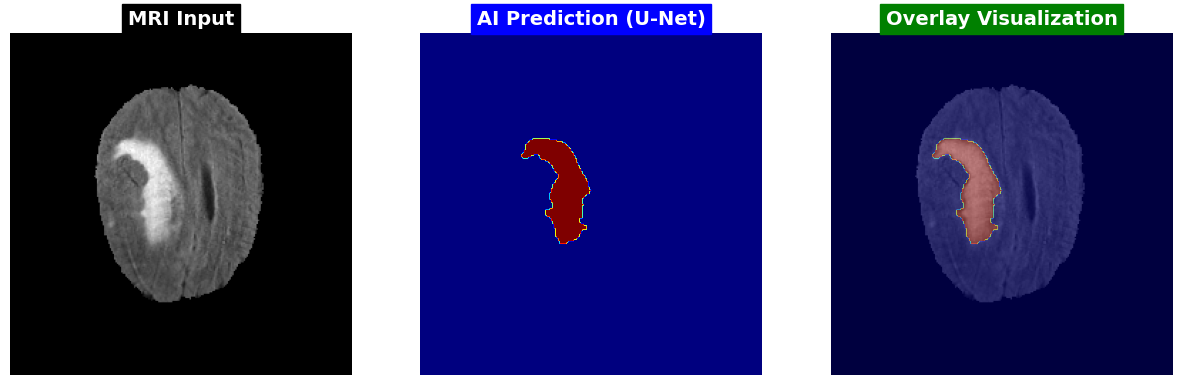

In [6]:
import matplotlib.pyplot as plt

# 1. 确保要在 CPU 上处理数据
img_show = img_tensor.cpu().numpy()[0, 0].T
lbl_show = lbl_tensor.cpu().numpy()[0, 0].T
pred_show = pred_binary.cpu().numpy()[0, 0].T

# 2. 画一张高清大图
plt.figure(figsize=(15, 5), dpi=100) # dpi=100 保证清晰度

# 左：原图
plt.subplot(1, 3, 1)
plt.imshow(img_show, cmap='gray', origin='lower')
plt.title("MRI Input", fontsize=14, fontweight='bold', color='white', backgroundcolor='black')
plt.axis('off')

# 中：AI 预测
plt.subplot(1, 3, 2)
plt.imshow(pred_show, cmap='jet', origin='lower')
plt.title("AI Prediction (U-Net)", fontsize=14, fontweight='bold', color='white', backgroundcolor='blue')
plt.axis('off')

# 右：叠在一起看 (Overlay) —— 这个最酷！
plt.subplot(1, 3, 3)
plt.imshow(img_show, cmap='gray', origin='lower')
plt.imshow(pred_show, cmap='jet', alpha=0.5, origin='lower') # alpha=0.5 半透明
plt.title("Overlay Visualization", fontsize=14, fontweight='bold', color='white', backgroundcolor='green')
plt.axis('off')

# 3. 保存到本地
plt.savefig("project.png", bbox_inches='tight', pad_inches=0.1)
print("✅ 高清结果图已保存为 'project.png'！快去文件夹里看看！")